In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import snapshot as sn
import h5py
import re

In [2]:
basePath = '../sims.TNG/TNG100-3/output/'
SnapNum = 99

In [3]:
simulation = (re.search(r'TNG(\d+-\d+)/', basePath)).group(1)
simulation

'100-3'

In [4]:
# Defining a function for unit conversion
def UnitConversion(array, unit):
    if unit == 'mass':
        array = array * 1e10 / h # In Msun unit
    if unit == 'length':
        array = array * a / (1e3 * h) # In Mpc unit
    if unit == 'physical':
        array = array / 1e3 # In Mpc unit
    return array

In [5]:
header = il.groupcat.loadHeader(basePath, SnapNum)
h = header['HubbleParam']
a = header['Time']
box_size = UnitConversion(header['BoxSize'], 'length')
h, a, box_size

(0.6774, 0.9999999999999998, 110.71744906997341)

In [6]:
snapshot_path = sn.snapPath(basePath, 99)
hdf = h5py.File(snapshot_path, 'r')
masses = hdf['Header'].attrs['MassTable']
mass_dm = UnitConversion(masses[1], 'mass')
mass_dm

477660982.7571062

In [7]:
halo_fields = ['GroupFirstSub']

In [8]:
sub_halo_ids = il.groupcat.loadHalos(basePath, SnapNum, fields=halo_fields)
tot_subhalos = len(sub_halo_ids)
tot_subhalos

124773

In [9]:
# n = 5 # Take a sample to cross-check

In [10]:
# for i in range(n):
#     mass = []
#     sub_halo_info = il.groupcat.loadSingle(basePath, SnapNum, subhaloID=sub_halo_ids[i])
#     if sub_halo_info['SubhaloLenType'][0] != 0:
#         p0_mass = UnitConversion(sn.loadSubhalo(basePath, SnapNum, sub_halo_ids[i], 0, fields='Masses'), 'mass')
#         p0_act = UnitConversion(sub_halo_info['SubhaloMassType'][0], 'mass')
#         mass.extend(p0_mass)

#     if sub_halo_info['SubhaloLenType'][1] != 0:
#         p1_mass = np.full(sub_halo_info['SubhaloLenType'][1], mass_dm)
#         p1_act = UnitConversion(sub_halo_info['SubhaloMassType'][1], 'mass')
#         mass.extend(p1_mass)

#     if sub_halo_info['SubhaloLenType'][4] != 0:
#         p4_mass = UnitConversion(sn.loadSubhalo(basePath, SnapNum, sub_halo_ids[i], 4, fields='Masses'), 'mass')
#         p4_act = UnitConversion(sub_halo_info['SubhaloMassType'][4], 'mass')
#         mass.extend(p4_mass)

#     if sub_halo_info['SubhaloLenType'][5] != 0:
#         p5_mass = UnitConversion(sn.loadSubhalo(basePath, SnapNum, sub_halo_ids[i], 5, fields='Masses'), 'mass')
#         p5_act = UnitConversion(sub_halo_info['SubhaloMassType'][5], 'mass')
#         mass.extend(p5_mass)

#     total_mass = UnitConversion(sub_halo_info['SubhaloMass'], 'mass')

#     print(f'For Subhalo id = {sub_halo_ids[i]}')
#     print('part0\t\tpart1\t\tpart4\t\tpart5\t\tTotal')
#     print('{:.7g}\t{:.7g}\t{:.7g}\t{:.7g}\t{:.7g}'.format(np.sum(p0_mass),np.sum(p1_mass),np.sum(p4_mass),np.sum(p5_mass),np.sum(mass)))
#     print('{:.7g}\t{:.7g}\t{:.7g}\t{:.7g}\t{:.7g}'.format(p0_act,p1_act,p4_act,p5_act,total_mass))
    
#     if i != n-1:
#         print('\n', end='')

In [11]:
sub_halo_fields = ['SubhaloLenType', 'SubhaloMass', 'SubhaloPos', 'SubhaloStellarPhotometricsMassInRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRadType', 'SubhaloMassInRadType', 'SubhaloMassType']

In [12]:
sub_halos = il.groupcat.loadSubhalos(basePath, SnapNum, fields=sub_halo_fields)

In [13]:
nonzero_stellar_ids = np.nonzero(sub_halos['SubhaloLenType'][:, 4] > 0)
tot_nonzero_stellar = len(nonzero_stellar_ids[0])
nonzero_stellar_ids[0], tot_nonzero_stellar

(array([     0,      1,      2, ..., 110192, 114632, 115568]), 21846)

In [14]:
sub_halo_pos = sub_halos['SubhaloPos'][nonzero_stellar_ids[0]]
sub_halo_mass = UnitConversion(sub_halos['SubhaloMass'][nonzero_stellar_ids[0]], 'mass')
sub_halo_stellar_mass = UnitConversion(sub_halos['SubhaloStellarPhotometricsMassInRad'][nonzero_stellar_ids[0]], 'mass')
sub_halo_stellar_mass_half = UnitConversion(sub_halos['SubhaloMassInHalfRadType'][nonzero_stellar_ids[0], 4], 'mass')
sub_halo_stellar_mass_max = UnitConversion(sub_halos['SubhaloMassInMaxRadType'][nonzero_stellar_ids[0], 4], 'mass')
sub_halo_stellar_mass_twice = UnitConversion(sub_halos['SubhaloMassInRadType'][nonzero_stellar_ids[0], 4], 'mass')
sub_halo_stellar_mass_total = UnitConversion(sub_halos['SubhaloMassType'][nonzero_stellar_ids[0], 4], 'mass')

In [15]:
partType = 4
fields = ['Coordinates', 'Masses']
critical_dist = UnitConversion(30, 'physical') # In physical kpc
critical_dist

0.03

In [16]:
total_stellar_mass = []

for i in range(tot_nonzero_stellar):
    stellar_info = sn.loadSubhalo(basePath, SnapNum, nonzero_stellar_ids[0][i], partType, fields=fields)
    coord = UnitConversion(stellar_info['Coordinates'] - sub_halo_pos[i], 'length')

    # Applying periodic boundary conditions
    np.where(coord[:, 0] > box_size/2, coord[:, 0] - box_size/2, coord[:, 0])
    np.where(coord[:, 1] > box_size/2, coord[:, 1] - box_size/2, coord[:, 1])
    np.where(coord[:, 2] > box_size/2, coord[:, 2] - box_size/2, coord[:, 2])

    dist = np.array(pow(coord[:, 0], 2) + pow(coord[:, 1], 2) + pow(coord[:, 2], 2))

    req_sh = np.nonzero(dist <= critical_dist)
    mass = np.sum(UnitConversion(stellar_info['Masses'][req_sh[0]], 'mass'))

    total_stellar_mass.append(mass)

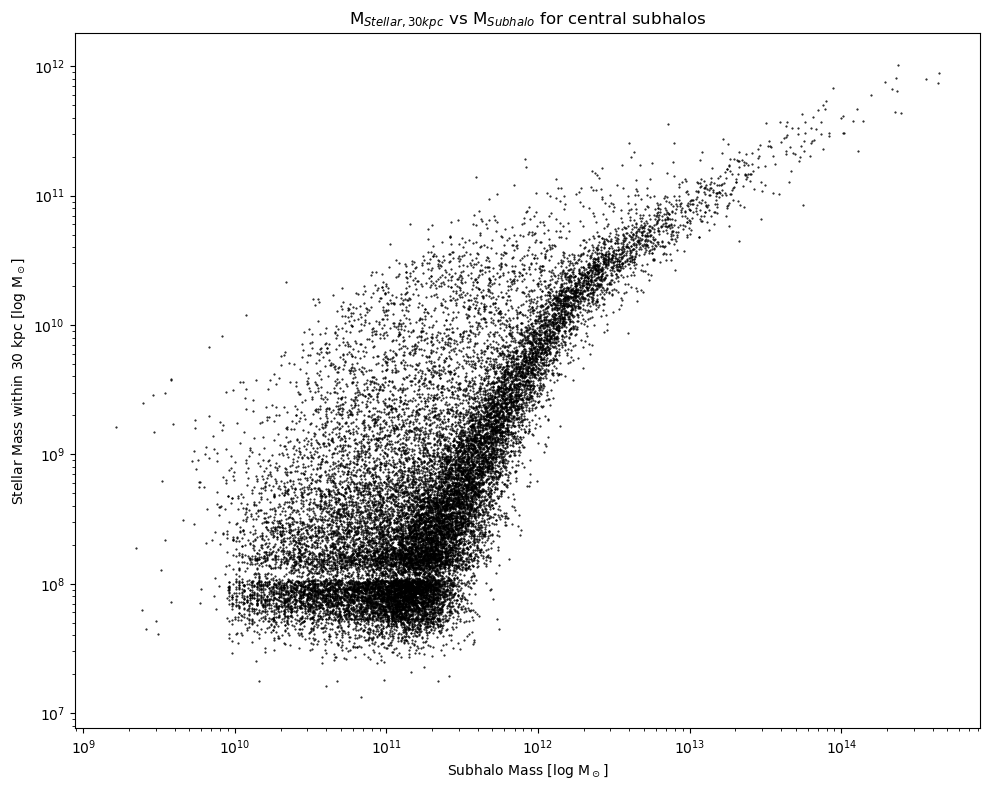

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_mass, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Subhalo Mass [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{Subhalo}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation}).png')
plt.tight_layout()
plt.show()

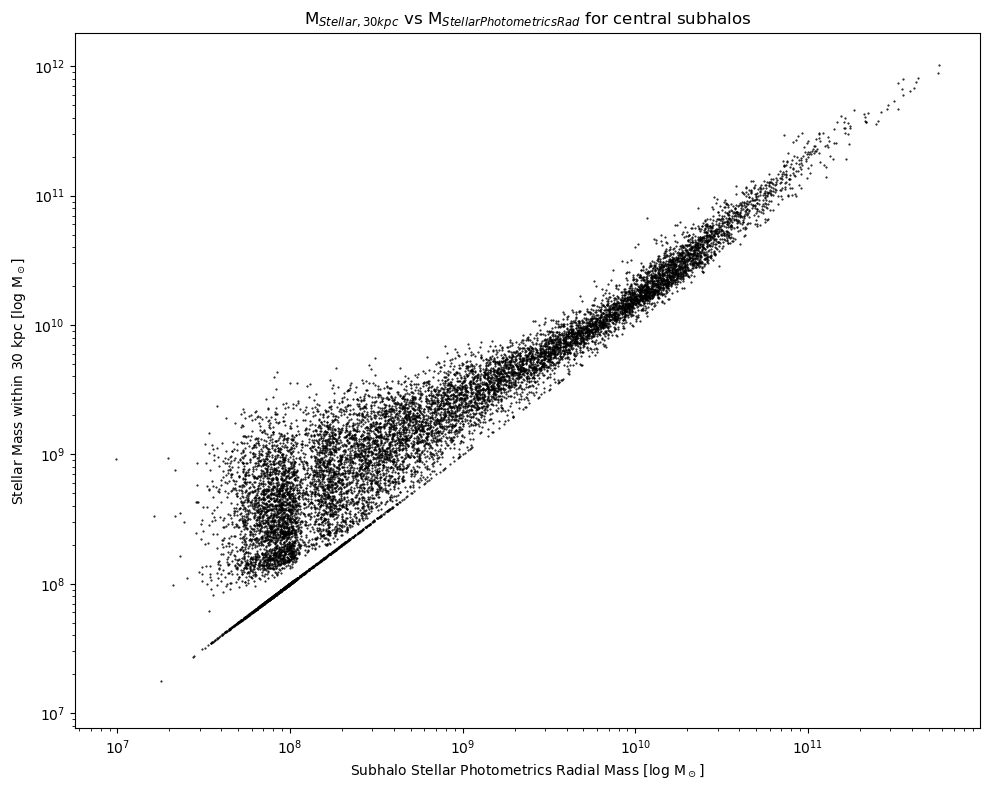

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_stellar_mass, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Subhalo Stellar Photometrics Radial Mass [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{StellarPhotometricsRad}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation})-2.png')
plt.tight_layout()
plt.show()

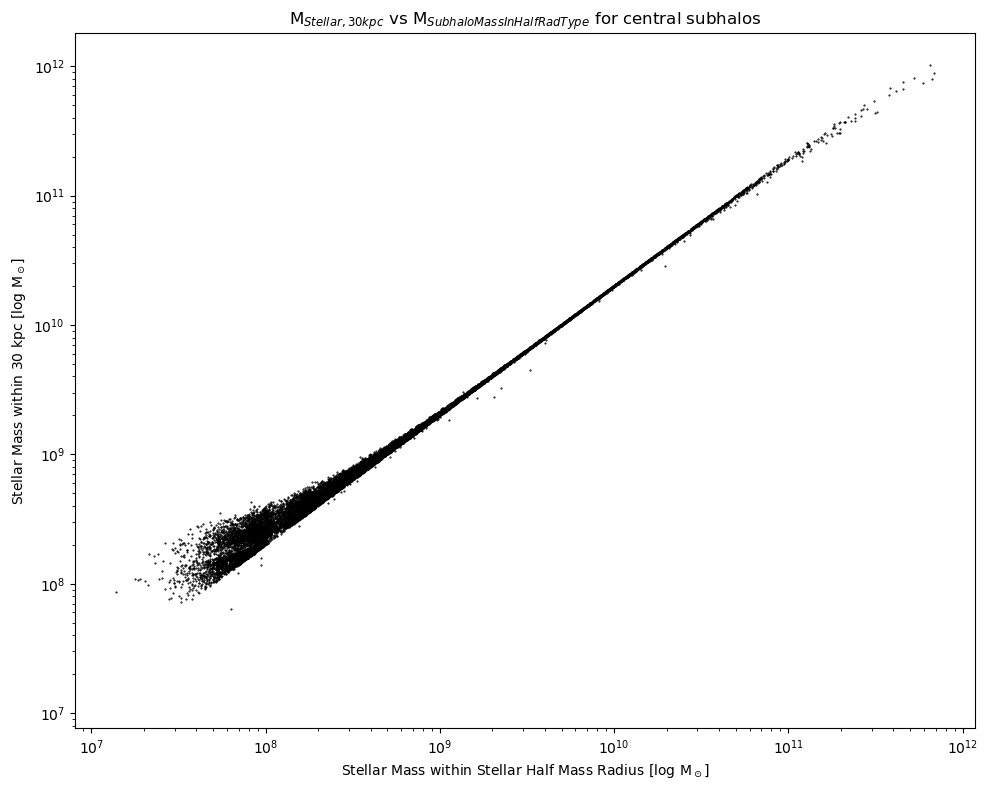

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_stellar_mass_half, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Stellar Mass within Stellar Half Mass Radius [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{SubhaloMassInHalfRadType}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation})-3.png')
plt.tight_layout()
plt.show()

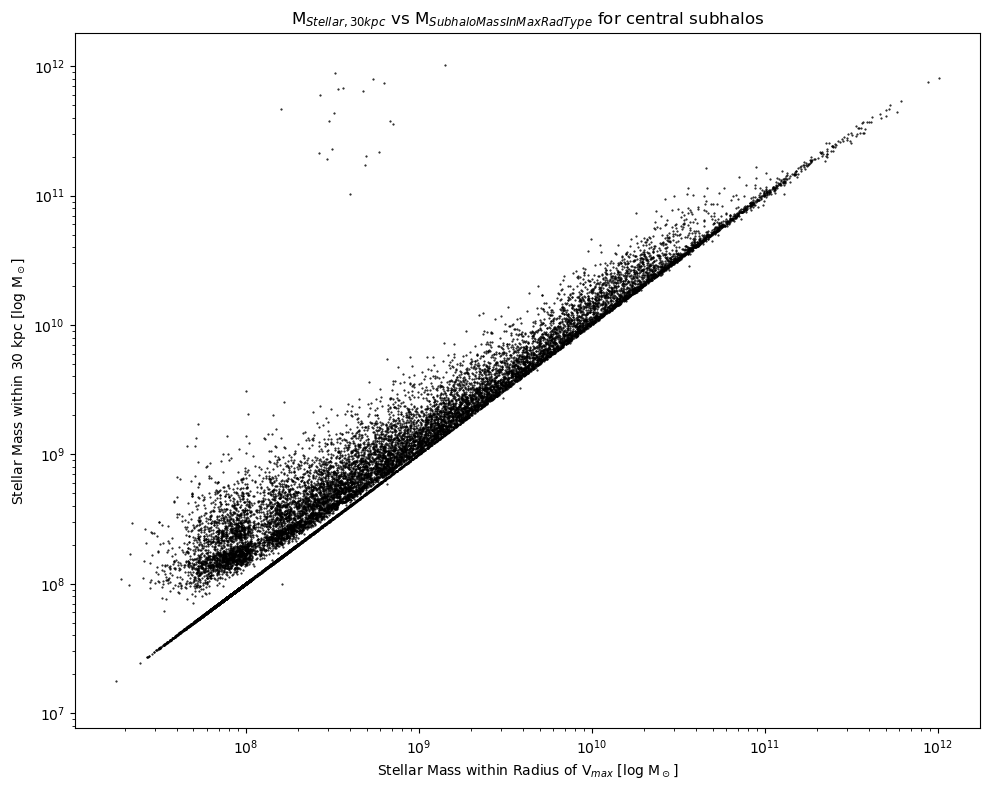

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_stellar_mass_max, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Stellar Mass within Radius of V$_{max}$ [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{SubhaloMassInMaxRadType}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation})-4.png')
plt.tight_layout()
plt.show()

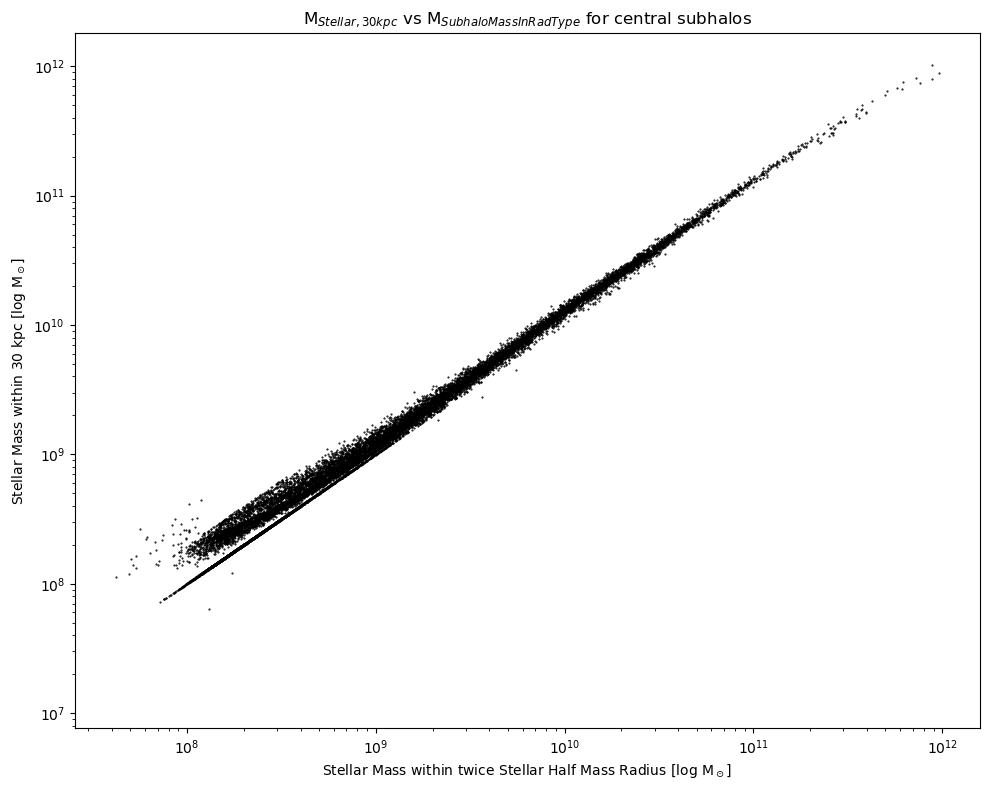

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_stellar_mass_twice, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Stellar Mass within twice Stellar Half Mass Radius [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{SubhaloMassInRadType}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation})-5.png')
plt.tight_layout()
plt.show()

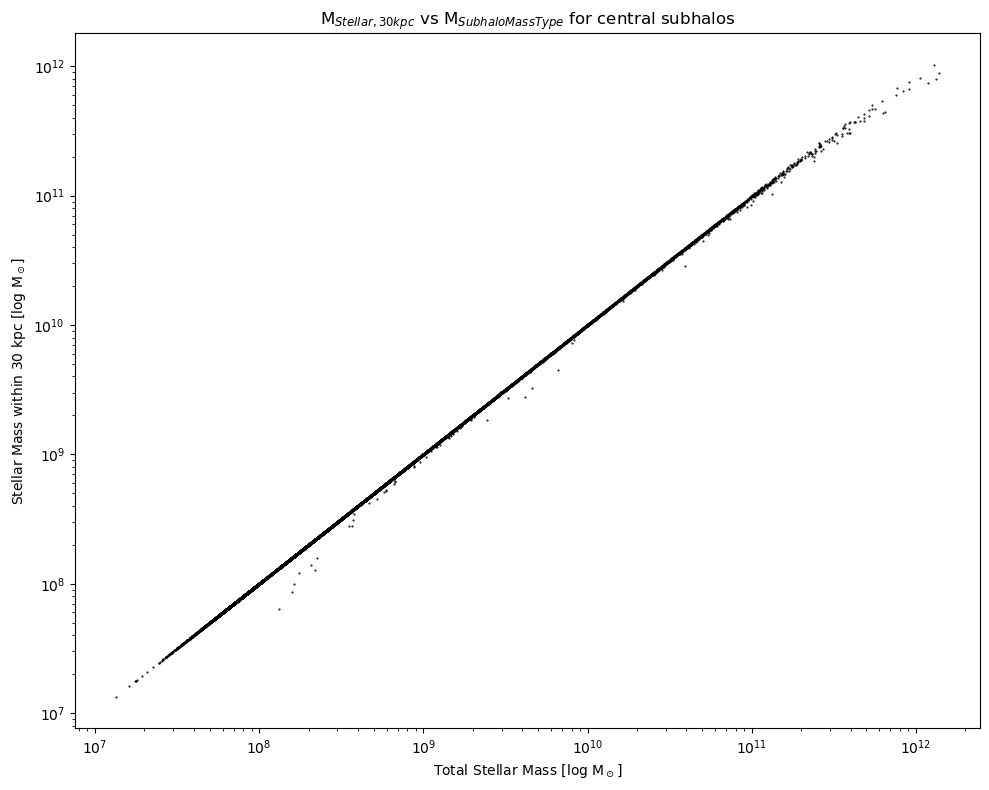

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_halo_stellar_mass_total, total_stellar_mass, 'k.', markersize=1, label='Subhalo Mass')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Total Stellar Mass [log M$_\odot$]')
ax.set_ylabel('Stellar Mass within 30 kpc [log M$_\odot$]')
plt.title('M$_{Stellar, 30kpc}$ vs M$_{SubhaloMassType}$ for central subhalos')
# plt.savefig(f'StellarMassWithin30kpc({simulation})-6.png')
plt.tight_layout()
plt.show()

Comments:$\newline$
-> Most of the stellar mass quantities given in the group catalog have a linear relationship with the stellar mass wihtin 30 kpc execpt the first one (Subhalo), which appear to have a logistic/sigmoidal growth.$\newline$
-> A possible explanation for this could be that the quantity Mass$_{Subhalo}$ takes into account all the particles of the subhalo/galaxy that are gravitationally bound to it, and since the dark matter has a vast majority in the universe (~70%), even as the stellar mass increases by a huge amount, the total subhalo mass increases very little.$\newline$
-> There appears to be a wide scatter in the plot against M$_{StellarPhotometricsRad}$, the reason for which could not be deduced properly.$\newline$
-> A lower cut-off limit for the masses appears due to the resolution of the corresponding simulation.